<center>

## <font color='blue'>ASTR 21100</font>
<center>

### <font color='blue'>"Computational Techniques in Astrophysics"</font>
    
<center>
    
### <font color='blue'>Computing distances to distant galaxies, quasars, and supernovae</font>

<center>
    
### <font color='blue'> 25 points (+ 2 possible extra-credit points)</font>
    
    
<center>

### <font color='blue'> Due Thursday,  Jan 25, 10pm</font>



### Introduction

You probably heard that our Universe expands. We know this because we see that almost all galaxies and quasars are moving away from us - the motion that is reflected in the spectral shift of the lines in their spectra towards longer wavelengths (redder light). The spectral shift (called *redshift*) is defined as $z = (\lambda - \lambda_{\rm lab})/\lambda_{\rm lab}$, where $\lambda_{\rm lab}$ is the wavelength of a line that we would measure in the lab here on Earth and $\lambda$ is the wavelength at which the line is observed in the spectrum of a galaxy or quasar.

Models of the expansion based on Einstein's theory of general relativity predict how the distance to a galaxy $d_L$ depends on redshift $z$. The distance $d_L$ also depends on the Hubble "constant" $H_0$ that characterizes the rate of expansion currently and on the contents of the Universe - the mean density of matter and energy that are expressed in the dimensionless quantities $\Omega_{\rm m0}$ and $\Omega_\Lambda$ defined relative to a reference density. 

In this homework you will implement and test a function that estimates an integral of input function $f(x)$ for the interval $[a,b]$ with the accuracy that is controlled by the input thresholds $\rm atol$ and $\rm rtol$ for absolute and relative accuracy of the estimate (exercise 1). You can do this by modifying a provided function implementing Romberg integration calculation using recursive function calls. In the process you should learn how the accuracy control works in such algorithms and understand what $\rm atol$ and $\rm rtol$ arguments of many package functions do. 

If you would like more challenge, try implementing Romberg integration on your own without using recursive calls. 

You will then test your function by using it to compute distance $d_L$ and compare result to the output of AstroPy's function computing $d_L$ in the exercise 2. 

In the exercise 3, you will use the $d_L$ function to produce figure similar to the figure 
from the paper by <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...746...85S/abstract">Suzuki et al. 2012</a> below, which uses many observational samples of <a href="https://en.wikipedia.org/wiki/Type_Ia_supernova">type Ia supernovae</a>. You will examine how the theoretical line in this figure depends on the absolute magnitude (intrinsic brightness) of these supernovae and on the parameters $\Omega_{\rm m0}$ and $\Omega_\Lambda$. 

If you are not familiar with these concepts, it will be useful if you review [Section 8.1](https://astro.uchicago.edu/~andrey/classes/a211w24/html/appendix/astro.html) of the notes. Please do not hesitate to ask for clarification, if something is not clear. 


<br>
<center><img width=500 src="https://astro.uchicago.edu/~andrey/classes/a211/img/suzuki_etal12_hubble_diagram.png"></img></center>

Import NumPy and Matplotlib, change Matplotlib defaults to produce nicer plots. 

In [1]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

# the following code make plots look better
def plot_prettier(dpi=150, fontsize=11, usetex=False): 
    '''
    Make plots look nicer compared to Matplotlib defaults
    Parameters: 
        dpi - int, "dots per inch" - controls resolution of PNG images that are produced
                by Matplotlib
        fontsize - int, font size to use overall
        usetex - bool, whether to use LaTeX to render fonds of axes labels 
                use False if you don't have LaTeX installed on your system
    '''
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    if usetex:
        plt.rc('text', usetex=usetex)
    else:
        plt.rcParams['mathtext.fontset'] = 'cm'
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plot_prettier()

## <font color='blue'>Exercise 1 (12 points): implementing numerical integration with error control</font>

#### Background

The Romberg integration approach starts with the trapezoidal estimate of the integral $\int_a^b f(x)dx$ done with step size $h$, $R_0(h)$, and step size $h/2$, $R_0(h/2)$ to construct the 4th order accurate estimate of the integral:
$$R_1(h) = \frac{4R_0(h/2) - R_0(h)}{3}.$$
Likewise, we can use the $R_1$ estimate for step sizes $h/2$ and $h$ and evaluate the integral using their combination: 
$$R_2(h) = \frac{16R_1(h/2) - R_1(h)}{15}.$$
This can continue and we can get the $2(m+1)$ order accurate estimate of the integral with the recursion relation: 
$$
R_{m}(h)=\frac{4^{m} R_{m-1}(h/2)-R_{m-1}(h)}{4^{m}-1},
$$

For any $R_m$ with $m>0$, we can estimate the error of the integral estimate as the absolute value of the difference between the current most accurate estimate $R_m(h)$ and the next accurate estimate we have $R_{m-1}(h/2)$: $\vert R_{m}(h)-R_{m-1}(h)\vert$.

We can use this fact to implement error control for the integration. Starting at $m=1$ and iterating using a for loop until some $m_{max}$ (which can be a keyword argument with a default value of say 10), $R_m(h)$ and the error $\vert R_{m}(h)-R_{m-1}(h)\vert$ (where $\vert\ldots\vert$ is absolute value) can be estimated and the iterations can be stopped when 

$$\vert R_{m}(h)-R_{m-1}(h/2)\vert<{\rm atol + rtol}\,\vert R_m(h)\vert,$$

where ${\rm atol}$ and ${\rm rtol}$ are the absolute and relative (fractional) error tolerances that we want from the result.
These arguments can be input keyword arguments to the integration function. 

When ${\rm atol>rtol}\,\vert R_m(h)\vert$ the iteration will be stopped when the absolute error threshold is satisfied. When ${\rm atol<rtol}\,\vert R_m(h)\vert$, the iteration will be stopped when the relative error threshold is satisfied. 


### Tasks

**Task 1a. (10 points)** Implement a function <tt>integrate</tt> that can numerically estimate integral for an input function over an interval $[a,b]$. The estimate should use the approach outlined above to ensure that the estimate returned by the function has an estimated uncertainty smaller than the specified ``thresholds'' (tolerance) ${\rm atol}$ and ${\rm rtol}$. 
A possible format of the function is outlined below. 

***Note:*** You can use function <tt>trapzd_h</tt> below in your calculation and <tt>romberg_recursive</tt> as an example. Note, however, that it cannot be used as given. It needs to be modified for the purposes of this exercise or a new function needs to be written.  

***Note:*** If you would like a more challenging version of this exercise, implement Romberg integration without recursive calls (which are slow) by computing a lower triangle of a table $R_{i}(h/2^k)$, where $i\in [0,m]$ and $k\in[0,m]$ to compute $R_m$. If you are interested to pursue this option, please contact instructor for more details and guidance.  
    
**Task 1b. (2 points)** Test your function by computing $$\int_0^1 e^x dx$$ by computing the fractional error of the numerical relative to exact value ($=e-1$) and show that the fractional error of the estimate is smaller than the specified threshold $\rm rtol$ for several values of the threshold (e.g., 1e-3, 1e-8, 1e-12). Make $\rm atol=10^{-16}$ for this exercise. 

Repeat the test by setting $\rm rtol=10^{-16}$ and computing the integral and absolute error for  $\rm atol=10^{-3}, 10^{-5}, 10^{-7}$. Make sure that results you are getting in these tests has error smaller than the specified tolerances. 

You can compare results to SciPy's function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romberg.html"><tt>scipy.integrate.romberg</tt></a> for the same values of the tolerance thresholds, as shown in the example below. 


    
    
    def integrate(func, a, b, *args, atol=1e-10, rtol=1e-6):
        '''
        function computing numerical estimate of the integral of function func over the interval [a,b] 
        the integral estimate is guaranteed to be in the range [2e-16, rtol] or [2e-16, atol

        Parameters:
            func: Python function object
                  function to integrate, must be able to handle numpy arrays as input
                  and should have inputs as func(x, *args)
            a, b: floats
                  limits of the integral
            atol: float - absolute error tolerance threshold
            rtol: float - the fractional error tolerance threshold

            args: pointer to a tuple of parameters to be passed for func, if any 

        Returns:
            float: value of the estimated int^b_a f(x)dx
            float: estimate of the absolute error
        '''

In [2]:
def trapzd_h(func, a, b, h, *args):
    """
    function implementing trapezoidal integration scheme using
    numpy vector operations
    
    Parameters:
        func: python function object
            function to integrate, must take numpy arrays as input
        a, b: floats
            limits of the integral
        h: float, step size to use, [a,b] must be evenly divisible by h  
        args: parameters to be passed for func, if any 
    
    Returns:
        float: trapezoidal scheme estimate of int^b_a f(x)dx
    """
    assert(h > 0); assert(a < b)
    ntrap = (b-a) / h
    # assert that [a,b] is divided by h into integer number of intervals
    if ntrap - int(ntrap) != 0.:
        raise ValueError(f'interval [{a:.3e}, {b:.3e}] must be exactly divisible by h = {h:.3e}')
    # if h = b - a
    if abs(h - (b-a)) + 1. == 1.:
        return 0.5*(func(a, *args) + func(b, *args)) * (b-a)
    else: 
        hstep = (b - a) / ntrap
        # np.arange creates an array of values from 0 to nstep-1
        xd = a + np.arange(1,ntrap) * hstep 
        return (0.5*(func(a, *args) + func(b, *args)) + np.sum(func(xd, *args))) * hstep


In [3]:
def romberg_recursive(func, a, b, h, *args, m=0):
    """
    Recursive implementation of Romberg integration of 
    the integral int_a^b f(x)dx with initial stepsize h
    up to the Romberg iteration m
    
    Parameters:
        func: Python function name
        a, b: floats, integration limits, b>a
        h: float, step size, must divide [a, b] evenly
        args: tuple, parameters to be passed to func, if needed
            (can be empty)
        m: iteration number for which to compute R_m
    Returns:
        float: estimated value of the integral
    """
    if m == 0: 
        return trapzd_h(func, a, b, h, *args)
    else:
        fact = 4**m 
        # R_m-1(h/2)
        r_mm1_hhalf = romberg_recursive(func, a, b, h/2, *args, m=m-1)
        # R_m-1(h)
        r_mm1_h = romberg_recursive(func, a, b, h, *args, m=m-1)
        # compute R_m(h) using recursion relation 
        rm_h = (fact*r_mm1_hhalf - r_mm1_h) / (fact - 1)
        return rm_h
    #modify code to compute error, start with m = 1
    #difference between 

In [4]:
from scipy.integrate import romberg

def integrate(func, a, b, *args, atol=1e-10, rtol=1e-6):
    '''
    function computing numerical estimate of the integral of function func over the interval [a,b] 
    the integral estimate is guaranteed to be in the range [2e-16, rtol] or [2e-16, atol

    Parameters:
        func: Python function object
              function to integrate, must be able to handle numpy arrays as input
              and should have inputs as func(x, *args)
        a, b: floats
              limits of the integral
        atol: float - absolute error tolerance threshold
        rtol: float - the fractional error tolerance threshold

        args: pointer to a tuple of parameters to be passed for func, if any 

    Returns:
        float: value of the estimated int^b_a f(x)dx
        float: estimate of the absolute error
    '''
    ei  = romberg(func, a, b, args = args,tol=atol, rtol=rtol)
    
    return ei, 0.


In [5]:
#copy
from scipy.integrate import romberg

def integrate(func, a, b, *args, atol=1e-10, rtol=1e-6, mmax = 15):
    '''
    function computing numerical estimate of the integral of function func over the interval [a,b] 
    the integral estimate is guaranteed to be in the range [2e-16, rtol] or [2e-16, atol

    Parameters:
        func: Python function object
              function to integrate, must be able to handle numpy arrays as input
              and should have inputs as func(x, *args)
        a, b: floats
              limits of the integral
        atol: float - absolute error tolerance threshold
        rtol: float - the fractional error tolerance threshold

        args: pointer to a tuple of parameters to be passed for func, if any 

    Returns:
        float: value of the estimated int^b_a f(x)dx
        float: estimate of the absolute error
    '''
    h = b-a 
    exact = (np.exp(b)-np.exp(a))
    for m in range (1, mmax):    
        rm_h  = romberg_recursive(func, a, b, h, *args, m = m)
        rmmin1_h2  = romberg_recursive(func, a, b, h, *args, m = m-1)
        abs_diff = np.abs(rm_h-rmmin1_h2)
        fracerr = rm_h/exact - 1.0
        abserr = abs(rm_h - exact)
        
        if abs_diff < atol + rtol:        
            return rm_h, abserr
            break
        else: 
            if m == mmax:
                print("mmax has been reached")
                return rm_h, abserr
            else:
                continue 
 

In [6]:
b = 1
a = 0
h = b-a
#tol = 1e-16
#args = [tol, atol]
rtol = [1e-3, 1e-8, 1e-12]
for i, t in enumerate (rtol):
    integral, abserr  = integrate(np.exp,a,b, atol = 1e-16, rtol = t)
    print("integral:", integral, "absolute error:", abserr)

integral: 1.7182826879247577 absolute error: 8.594657125993166e-07
integral: 1.7182818284590782 absolute error: 3.3084646133829665e-14
integral: 1.7182818284590449 absolute error: 2.220446049250313e-16


In [7]:
#test #2
b = 1
a = 0
h = b-a
#args = [tol, atol]
atol = [1e-3, 1e-5, 1e-7]
for i, o in enumerate (atol):
    integral, abs_error  = integrate(np.exp,a,b, atol = o, rtol = 1e-16)
    print("integral:", integral, "absolute error:", abs_error)

integral: 1.7182826879247577 absolute error: 8.594657125993166e-07
integral: 1.7182818287945305 absolute error: 3.354854172243904e-10
integral: 1.7182818284590782 absolute error: 3.3084646133829665e-14


#### <font color='darkblue'>Example of using scipy.integrate.romberg


In [8]:
from scipy.integrate import romberg

a, b = 0, 1
func = np.exp
exact = (np.exp(b)-np.exp(a))
for rtol in [1.e-2, 1e-4, 1e-6, 1e-8, 1e-10]:
    # tol is the absolute error threshold
    # rtol is the relative error threshold
    ei  = romberg(func, a, b, tol=1e-16, rtol=rtol) 
    fracerr = ei/exact - 1.0
    abserr = abs(ei - exact)
    print(f'for tol = {rtol:.2e}, abs_error = {abserr:.5e},  frac_error = {fracerr:.5e}')
    #fracerror --> 

for tol = 1.00e-02, abs_error = 8.59466e-07,  frac_error = 5.00189e-07
for tol = 1.00e-04, abs_error = 3.35485e-10,  frac_error = 1.95245e-10
for tol = 1.00e-06, abs_error = 3.35485e-10,  frac_error = 1.95245e-10
for tol = 1.00e-08, abs_error = 3.30846e-14,  frac_error = 1.93179e-14
for tol = 1.00e-10, abs_error = 2.22045e-16,  frac_error = 2.22045e-16


## <font color='blue'>Exercise 2 (4 points + 2 extra credit): implementing and testing a function to compute luminosity distance $d_L$</font>


**2a (2 points).** Use the function you implemented in exercise 1 as a function integrate in the function <tt>d_l</tt> below in this line: 

            dc = integrate(dl_func, 0, z, *args, atol=atol, rtol=rtol)[0]

This function computes the cosmological distance $d_L$ for a redshift $z$. Expressions for $d_L$ for different values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ can be found in the [Section 8.1.4](https://astro.uchicago.edu/~andrey/classes/a211w24/html/appendix/astro.html#d-l-for-general-models-with-omega-lambda-ne-0) of the notes.  

***Note:*** The line of code above assumes that the function integrates returns two floats: integral value and an estimate of its absolute error and extracts only the value of the integral with [0] at the end. 

***Note:*** If you did not manage to get the integration function working in exercise 1, you can use SciPy's function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.romberg.html"><tt>scipy.integrate.romberg</tt></a>, as shown above, here to compute $d_L$. 


**2b (2 point).** Test your function by running it and comparing its output to the estimates using AstroPy function for several pairs of $\Omega_{\rm m0}$ and $\Omega_\Lambda$: $[0.3, 0.7]$, $[0.1,0.9]$, $[0.8,0.1]$, as shown below (keep $H_0=70$). Try this comparison for $z=1$ and for $z=15$. For all cases, compute and print out $d_L$ using <tt>d_l</tt> function with your function <tt>integrate</tt> and the <tt>d_l_astropy</tt> that uses astropy function below. Make sure that the results are accurate within atol and rtol values that you specify. 

***Note:*** If you do not have AstroPy installed, you can install it. If you use Anaconda Python distribution do

    conda install astropy
   
in the Conda shell. Otherwise, do 

    pip install astropy

**2c (extra-credit, 2 points)**. If you look at the AstroPy documentation you will not find information about the accuracy with which the AstroPy function computes $d_L$. Try to determine the accuracy experimentally using <tt>d_l</tt> function. For $\Omega_{\rm m0}=0.3$ and $\Omega_\Lambda=0.7$ and $H_0$ compute $d_L$ using functions <tt>d_l</tt> and <tt>d_l_astropy</tt> for different input values of <tt>rtol</tt> argument to the former of 1e-6, 1e-10, 1e-13, 1e-15. Print out the values of $d_L$ computed by both functions and the fractional difference between the estimates. Examine the result and present an argument of the fractional error with which the AstroPy function computes $d_L$.  


In [9]:
def d_L_no_de(z, H0, Om0, clight = 2.99792458e5):
    '''
    function estimating d_L in Mpc, works only for models with OmL = 0
    
    Parameters:
    -----------
        z - float(s), a float or a numpy vector of floats containing redshift(s) for which to compute d_L
        H0 - Hubble constant in km/s/Mpc
        Om0 - dimensionless mean matter density in units of the critical density
        
    Returns:
    --------
        d_L - float(s), float or numpy vector of floats containing d_L in Mpc for inpute value(s) of z

    '''
    assert(Om0 >=0)
    q0 = 0.5 * Om0
    q0z = q0 * z
    return clight * z/H0 * (1. + (z-q0z) / (1. + q0z + np.sqrt(1. + 2.*q0z)))  

The function below implements this equation for calculation of $d_L$ for arbitrary values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ (see [Sections 8.1.2-8.1.4](https://astro.uchicago.edu/~andrey/classes/a211w24/html/appendix/astro.html) in the notes):

$$
d_L(z, H_0,\Omega_{\rm m0},\Omega_\Lambda) = \frac{c}{H_0}\,(1+z)\,\left\{
\begin{array}{ll}
\frac{1}{\sqrt{\Omega_k}}\,\sinh\left[\sqrt{\Omega_k}\,d_{\rm c}\right] & {\rm for}~\Omega_k>0 \\
d_{\rm c} & {\rm for}~\Omega_k=0 \\
\frac{1}{\sqrt{|\Omega_k|}}\,\sin\left[\sqrt{|\Omega_k|}\,d_{\rm c}\right] & {\rm for}~\Omega_k<0
\end{array}
\right.
$$
where $\Omega_k = 1-\Omega_{\rm m0} - \Omega_\Lambda$, $c=2.99792458\times 10^5$ km/s is speed of light in km/s, $H_0$ is the Hubble constant in km/s/Mpc (current observations indicate that $H_0$ is close to $70$ km/s although values between 65 and 74 are possible.

Numerical estimate of the integral is needed to compute $d_c$:

$$d_c =\int\limits_0^z \frac{dx}{E(x)},$$
where $E(x)=\sqrt{\Omega_{\rm m0}(1+x)^3+\Omega_k(1+x)^2+\Omega_\Lambda}.$





In [10]:
def dl_func(z, H0, Om0, OmL, Omk):
    z1 = 1.0 + z; z12 = z1 * z1
    return 1.0 / np.sqrt(z12*(Om0*z1 + Omk) + OmL)

In [11]:
clight = 2.99792458e5 # speed of light in km/s

def d_l(z, H0, Om0, OmL, atol=1e-16, rtol=1.e-8):
    """
    function computing luminosity distance from z=0 to z 
    using helper routine for comoving distance _dc
    
    Parameters:
    -----------
    z: float - redshift to which to compute d_L
    H0: float - Hubble constant in units of km/s/Mpc
    Om0: float - dimensionless mean matter density in the universe, >= 0
    OmL: float - dimensionless mean vacuum energy density in the universe
    hstep: float - step size to use
     
    Returns:
    --------
    float - value of d_L(z, H0, Om0, OmL) 
            estimated using function integrate with input atol and rtol tolerances
    """
    # if OmL == 0
    if 1.0+OmL == 1.0: 
        return d_L_no_de(z, H0, Om0) # if OmL=0, use simple formula without integration
    else: # otherwise use numerical integration to compute distance 
        dH = clight / H0 
        Omk = 1.0 - Om0 - OmL
        args = [H0, Om0, OmL, Omk]
        dc = integrate(dl_func, 0, z, *args, atol=atol, rtol=rtol)[0]
        if 1.0 + Omk == 1.0:
            return dH * dc * (1.0 + z)
        else:
            sqrOmk = np.sqrt(np.abs(Omk))
            if Omk > 0.:
                return dH * np.sinh(dc*sqrOmk) * (1.0 + z) / sqrOmk 
            else:
                return dH * np.sin(dc*sqrOmk) * (1.0 + z) / sqrOmk
            


In [12]:
# d_L function from Astropy for testing
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_astropy(z, H0, om0, oml):
    cosmo = LambdaCDM(H0=H0, Om0=om0, Ode0=oml)
    return cosmo.luminosity_distance(z=z) / u.Mpc

In [13]:
#2a---------------------------------------------------------------------------------------->
z = 13
args = 70, 0.3, 0.3, 0.4
atol = 1.00e-10
dc = integrate(dl_func, 0, z, *args, atol=atol, rtol=rtol)[0]
print (dc)

2.079414659110628


In [14]:
#2b----------------------------------------------------------------------------------------> come back!
z = [1, 15]
m0 = [0.3, 0.1, 0.8]
lamb = [0.7, 0.9, 0.1]
rtol = 1e-10
for i, r in enumerate (z):  
    for j, (m, l) in enumerate(zip(m0, lamb)):
        #print z
        #try different r_tol values
        d = d_l(r, 70, m, l, rtol = rtol)
        da = d_l_astropy(r,70,m,l)
        frac_error = abs(d-da)/da
        print ("d_l:", d, "d_l_astropy:", da, "fractional error:", frac_error)


d_l: 6607.6576117749355 d_l_astropy: 6607.657611774941 fractional error: 8.258551715683896e-16
d_l: 7655.298063878862 d_l_astropy: 7655.298063879043 fractional error: 2.3642377363044557e-14
d_l: 5273.053436326755 d_l_astropy: 5273.053436326777 fractional error: 4.139512922849428e-15
d_l: 163925.97027849947 d_l_astropy: 163925.97027849953 fractional error: 3.5508504732091193e-16
d_l: 241742.56773274462 d_l_astropy: 241742.56773274567 fractional error: 4.334105930407432e-15
d_l: 115694.07013692557 d_l_astropy: 115694.07013692564 fractional error: 6.288963302589513e-16


## <font color='blue'>Exercise 3 (9 points): using $d_L$ calculation to compute distance modulus of supernovae Type Ia</font>
    
The code snippet below reads data from the study of <a href="https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..22B/abstract">Betoule et al. (2014)</a>, which was downloaded <a href="http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html">here</a>. The function uses numpy loadtxt function, which allows to read well formatted columns of data in the ASCII format easily. 
    
After reading numpy array <tt>zsn</tt> contains redshifts of 740 supernovae, while arrays <tt>msn</tt>, $m$, and <tt>emsn</tt> contain measured apparent magnitudes and their uncertainties
    
    
Distance modulus is defined as 
    
$$\mu = m - M = 5\log_{10}d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda) + 25.$$

where $d_L$ is distance in Megaparsecs and $M$ is the absolute magnitude of the supernovae (this is the magnitude supernova would have at a fixed distance of 10 parsecs). For this exercise we will assume that supernovae are perfect standard candles, which means that $M$ has a single value for all of them. This means that we should be able to predict what apparent magnitudes of supernovae should be at different redshifts: 
    
$$m_{\rm pred} = M + 5\log_{10}d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda) + 25.$$
    
**Task 3a (4 points).** plot supernovae data as a scatter of points in the $m-z$ plane and plot $m_{\rm pred}(z)$ for a grid of $z$ values in the range $z\in [0,2]$ as a line. Add a legend to your plot that describes points and the line. 
Make sure your plot is sufficiently large, axes are labeled and font size in the axis labels and legend is sufficiently large to be legible.
        
**Task 3b (4 points).** Try different values of $M$ in the range from 0 to -25, and values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ in the range $[0,1]$, while keeping $H_0=70$ and try to find a combination of $M$, $\Omega_{\rm m0}$ and $\Omega_\Lambda$ for which the line matches the supernova data best. Plot a plot of $m-z$ described above for this "best-fit" parameter combination and report the parameter values. 
    
**Task 3c (1 point).** Summarize your conclusions and quote the best values of $M$, $\Omega_{\rm m0}$ and $\Omega_\Lambda$ that you found. 
    

***Note:*** Useful Matlotlib functions: <tt>plt.xlabel, plt.ylabel, plt.scatter, plt.plot, plt.legend
    

In [15]:
def read_jla_data(sn_list_name = None):
    """
    read in table with the JLA supernova type Ia sample
    
    Parameters
    ----------
    sn_list_name: str
        path/file name containing the JLA data table in ASCII format
        
    Returns
    -------
    zsn, msn, emsn - numpy float vectors containing 
                       zsn: SNIa redshifts in the CMB frame
                       msn, emsn: apparent B-magnitude and its errors
    """
    zsn, msn, emsn = np.loadtxt(sn_list_name, usecols=(1, 4, 5),  unpack=True)

    return zsn, msn, emsn


In [16]:
# read vectors of redshifts, apparent magnitude in B-band, mB, and its uncertainty emB:
zsn, msn, emsn = read_jla_data(sn_list_name = 'https://astro.uchicago.edu/~andrey/classes/a211/data/jla_lcparams.txt')
nsn = np.size(zsn)
print("read sample of %d supernovae..."%(nsn))

read sample of 740 supernovae...


In [17]:
#3a---------------------------------------------------------------------------------------->
z = np.linspace(0.,2.,740)
mp = np.array([])
H0 = 70.
Om0 = 1.0
Oml = 0.
for i, r in enumerate (z):
    abs_mag = -17.
    mpred = abs_mag + 5*(np.log10(d_l(r, H0, Om0, Oml))) + 25
    mp = np.append(mp, mpred)

/var/folders/yv/z1dch3dj5wx3188lknqcwcc00000gn/T/ipykernel_64756/4001288225.py:9: RuntimeWarning: divide by zero encountered in log10
  mpred = abs_mag + 5*(np.log10(d_l(r, H0, Om0, Oml))) + 25


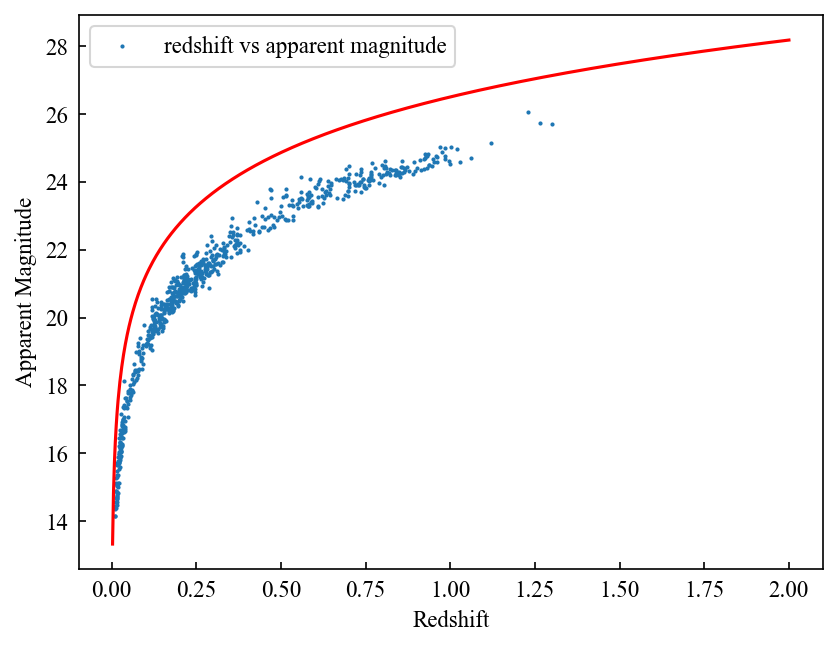

In [18]:
#3a---------------------------------------------------------------------------------------->
plt.scatter(zsn, msn, s = 1)
plt.plot(z, mp, color = 'r')
plt.xlabel('Redshift')
plt.ylabel('Apparent Magnitude')
plt.legend(["redshift vs apparent magnitude"])
plt.show()

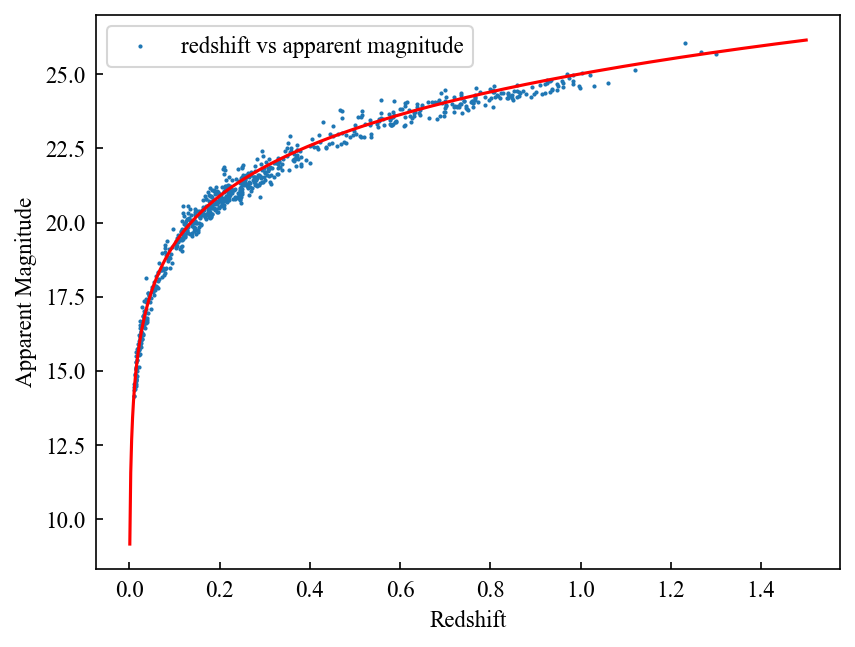

In [20]:
#3b---------------------------------------------------------------------------------------->
z = np.linspace(0.001,1.5,740)
mp = np.array([])
H0 = 70.
Om0 = 0.2
Oml = 0.3
for i, r in enumerate (z):
    abs_mag = -19.
    mpred = abs_mag + 5*(np.log10(d_l(r, H0, Om0, Oml))) + 25
    mp = np.append(mp, mpred)

plt.scatter(zsn, msn, s = 1)
plt.plot(z, mp, color = 'r')
plt.xlabel('Redshift')
plt.ylabel('Apparent Magnitude')
plt.legend(["redshift vs apparent magnitude"])
plt.show()

#My answer for 3b: values of -19 for absolute magnitude, 0.2 for omegam0 and 0.3 for omega_lambda seem to give me the best fit